# BeCoMe Method Visualization

This notebook demonstrates the results of the BeCoMe method on three datasets from Czech public policy.

## Table of Contents

1. [Data Loading](#section-data)
2. [Triangular Membership Functions](#section-tfn)
3. [Centroid Chart](#section-centroid)
4. [Sensitivity Analysis](#section-sensitivity)
5. [Comparison Dashboard](#section-dashboard)
6. [Accuracy Indicator](#section-gauge)
7. [Conclusion](#section-conclusion)

---

In [1]:
# Imports
import os
import sys
from pathlib import Path

import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.gridspec import GridSpec

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

# Path definitions - English version of data
data_dir = Path(os.getcwd()) / ".." / ".." / "data" / "en"
output_dir = Path(os.getcwd()) / "output"

from examples.utils.analysis import calculate_agreement_level
from examples.utils.data_loading import load_data_from_txt
from src.calculators.become_calculator import BeCoMeCalculator

# Plot settings
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

<a id="section-data"></a>

## 1. Data Loading

Loading three datasets: budget (22 experts), floods (13 experts), pendlers (22 experts).

In [2]:
# Budget case
budget_opinions, budget_metadata = load_data_from_txt(str(data_dir / "budget_case.txt"))
budget_calculator = BeCoMeCalculator()
budget_result = budget_calculator.calculate_compromise(budget_opinions)

# Floods case
floods_opinions, floods_metadata = load_data_from_txt(str(data_dir / "floods_case.txt"))
floods_calculator = BeCoMeCalculator()
floods_result = floods_calculator.calculate_compromise(floods_opinions)

# Pendlers case
pendlers_opinions, pendlers_metadata = load_data_from_txt(str(data_dir / "pendlers_case.txt"))
pendlers_calculator = BeCoMeCalculator()
pendlers_result = pendlers_calculator.calculate_compromise(pendlers_opinions)

print("Data loaded:")
print(f"  Budget: {len(budget_opinions)} experts, δ_max = {budget_result.max_error:.2f}")
print(f"  Floods: {len(floods_opinions)} experts, δ_max = {floods_result.max_error:.2f}")
print(f"  Pendlers: {len(pendlers_opinions)} experts, δ_max = {pendlers_result.max_error:.2f}")

Data loaded:
  Budget: 22 experts, δ_max = 2.20
  Floods: 13 experts, δ_max = 5.97
  Pendlers: 22 experts, δ_max = 5.68


<a id="section-tfn"></a>

## 2. Triangular Membership Functions

The chart shows all expert estimates as triangles.
Colored lines indicate aggregation methods: Γ (mean), Ω (median), compromise.

In [3]:
def plot_triangular_membership_functions(opinions, result, title, case_name, unit=""):
    """Visualization of triangular membership functions for all experts."""
    _fig, ax = plt.subplots(figsize=(14, 7))

    expert_color = "lightblue"
    expert_alpha = 0.3
    mean_color = "#FF6B6B"
    median_color = "#4ECDC4"
    compromise_color = "#FFD93D"

    for opinion in opinions:
        lower = opinion.opinion.lower_bound
        peak = opinion.opinion.peak
        upper = opinion.opinion.upper_bound
        x = [lower, peak, upper, lower]
        y = [0, 1, 0, 0]
        ax.fill(x, y, color=expert_color, alpha=expert_alpha, edgecolor="gray", linewidth=0.5)

    def draw_aggregate_triangle(fuzzy_num, color, label, linewidth=3):
        x = [fuzzy_num.lower_bound, fuzzy_num.peak, fuzzy_num.upper_bound, fuzzy_num.lower_bound]
        y = [0, 1, 0, 0]
        ax.plot(x, y, color=color, linewidth=linewidth, label=label, zorder=5)
        ax.fill(x, y, color=color, alpha=0.15, zorder=4)

    mean_label = f"Γ (mean)\nCentroid: {result.arithmetic_mean.centroid:.2f} {unit}".strip()
    median_label = f"Ω (median)\nCentroid: {result.median.centroid:.2f} {unit}".strip()
    compromise_label = (
        f"ΓΩMean (compromise)\nCentroid: {result.best_compromise.centroid:.2f} {unit}".strip()
    )

    draw_aggregate_triangle(result.arithmetic_mean, mean_color, mean_label)
    draw_aggregate_triangle(result.median, median_color, median_label)
    draw_aggregate_triangle(result.best_compromise, compromise_color, compromise_label)

    ax.set_xlabel("Value", fontsize=12, fontweight="bold")
    ax.set_ylabel("Membership degree μ(x)", fontsize=12, fontweight="bold")
    ax.set_title(
        f"{title}\nTriangular Membership Functions ({len(opinions)} experts)",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_ylim(-0.05, 1.1)
    ax.legend(fontsize=11, loc="upper right")
    ax.grid(True, alpha=0.3)

    expert_patch = mpatches.Patch(
        facecolor=expert_color, alpha=expert_alpha, edgecolor="gray", label="Expert estimates"
    )
    handles, labels = ax.get_legend_handles_labels()
    handles.insert(0, expert_patch)
    labels.insert(0, "Expert estimates")
    ax.legend(handles, labels, fontsize=11, loc="upper right")

    plt.tight_layout()
    plt.savefig(output_dir / f"{case_name}_membership_functions.png", dpi=300, bbox_inches="tight")
    plt.show()

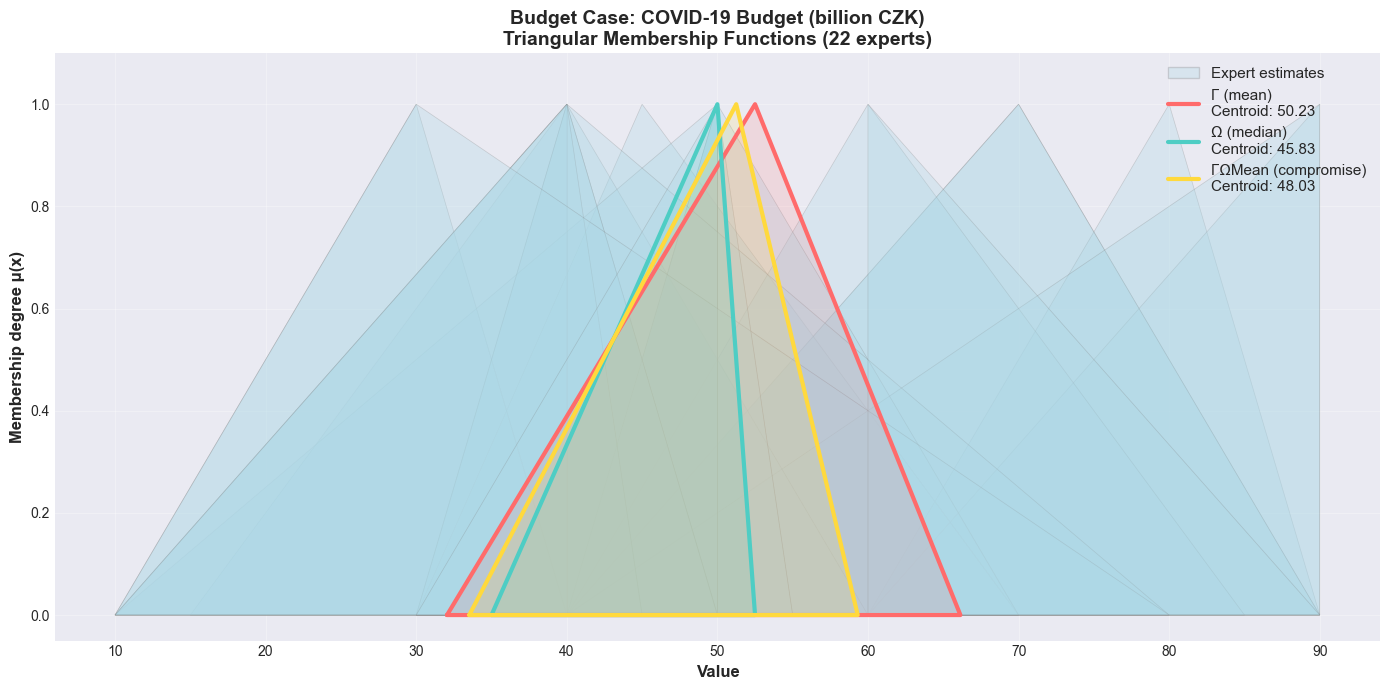

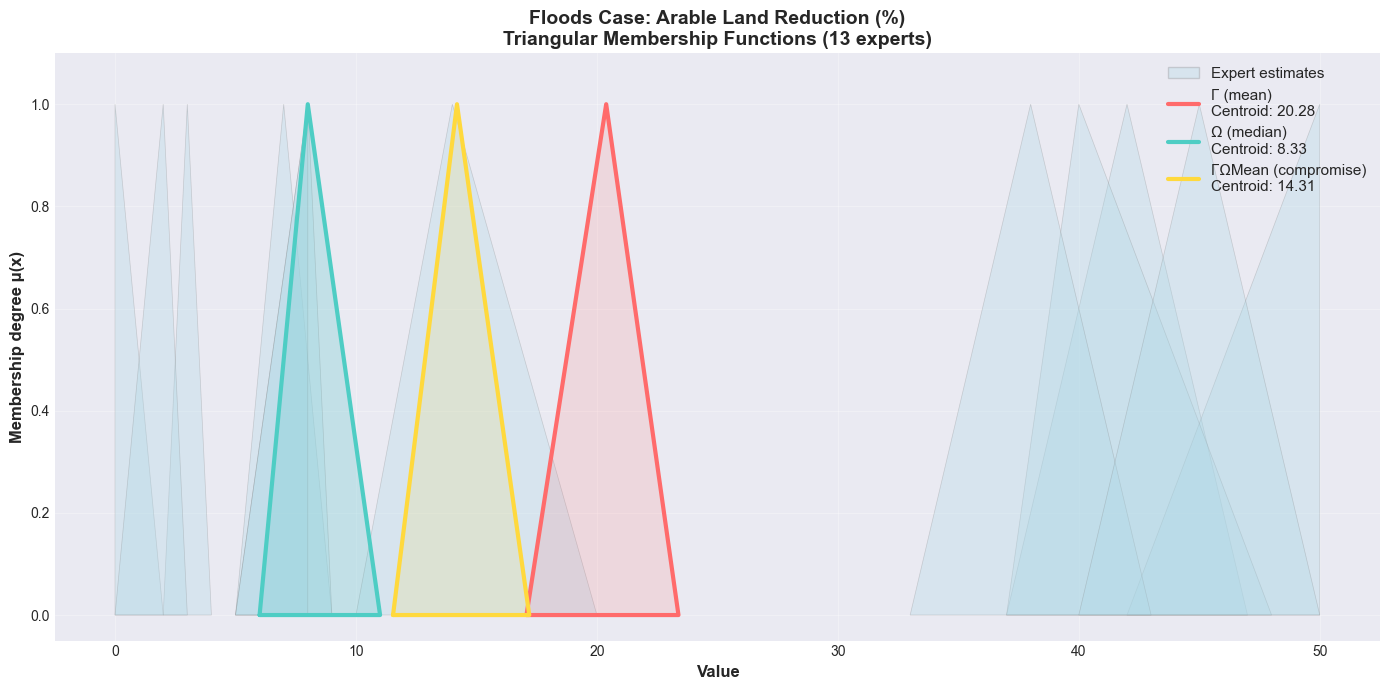

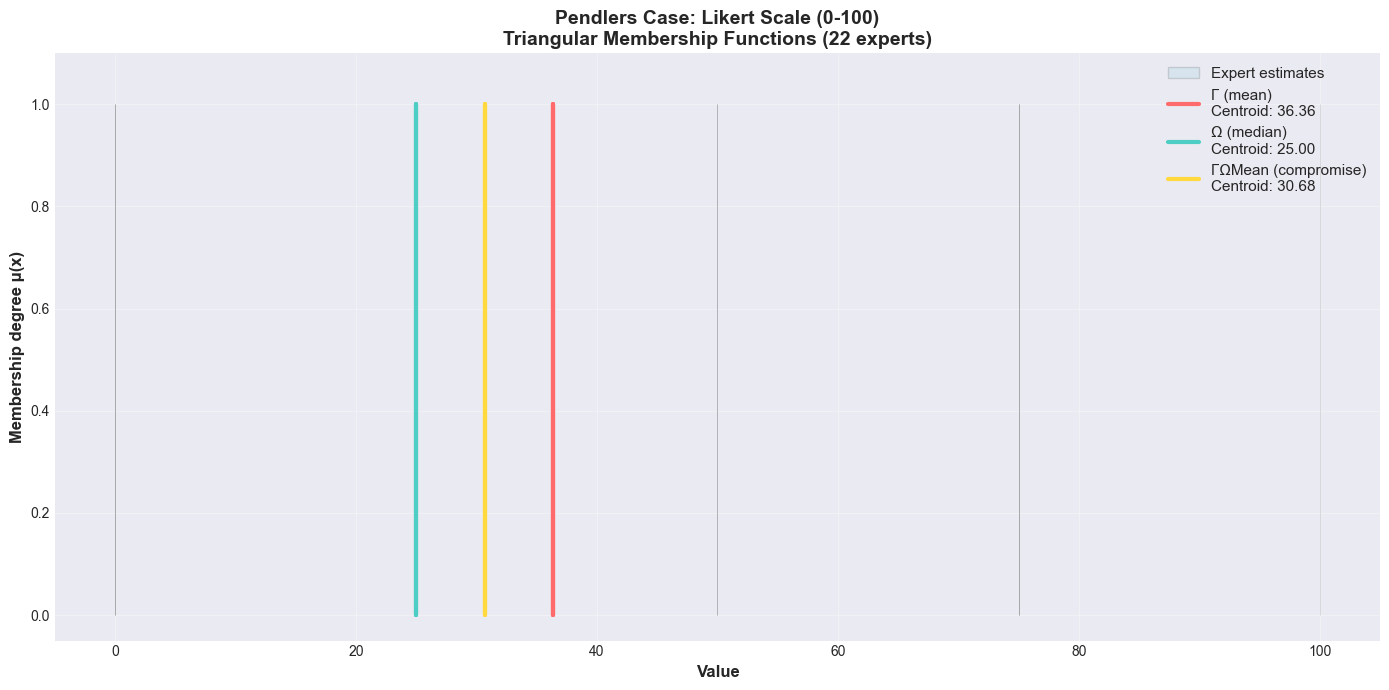

In [4]:
plot_triangular_membership_functions(
    budget_opinions, budget_result, "Budget Case: COVID-19 Budget (billion CZK)", "budget"
)
plot_triangular_membership_functions(
    floods_opinions, floods_result, "Floods Case: Arable Land Reduction (%)", "floods"
)
plot_triangular_membership_functions(
    pendlers_opinions, pendlers_result, "Pendlers Case: Likert Scale (0-100)", "pendlers"
)

### Interpretation

**Budget:** Experts agree (δ_max = 2.20), estimates lie in the range of 45-60 billion CZK. All aggregates are close together.

**Floods:** Distribution is bimodal (δ_max = 5.97). Experts are divided into two groups: conservative (0-10%) and radical (25-40%).

**Pendlers:** Agreement is strong with one outlier (δ_max = 5.68). Most experts are in a narrow band of 24-26.

<a id="section-centroid"></a>

## 3. Centroid Chart

The centroid represents the center of gravity of the triangle. Experts are sorted from lowest to highest centroid.
The distance between Γ and Ω lines determines the δ_max value.

In [5]:
def plot_centroid_chart(opinions, result, title, case_name):
    """Centroid chart of experts with marked aggregated values."""
    sorted_opinions = sorted(opinions, key=lambda op: op.centroid)
    expert_ids = [op.expert_id for op in sorted_opinions]
    centroids = [op.centroid for op in sorted_opinions]
    df = pd.DataFrame({"expert_id": expert_ids, "centroid": centroids})

    _fig, ax = plt.subplots(figsize=(14, 7))

    ax.bar(
        range(len(df)),
        df["centroid"],
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
    )

    mean_centroid = result.arithmetic_mean.centroid
    median_centroid = result.median.centroid
    compromise_centroid = result.best_compromise.centroid

    ax.axhline(
        y=mean_centroid,
        color="#FF6B6B",
        linestyle="--",
        linewidth=2.5,
        label=f"Γ (mean): {mean_centroid:.2f}",
        zorder=5,
    )
    ax.axhline(
        y=median_centroid,
        color="#4ECDC4",
        linestyle="--",
        linewidth=2.5,
        label=f"Ω (median): {median_centroid:.2f}",
        zorder=5,
    )
    ax.axhline(
        y=compromise_centroid,
        color="#FFD93D",
        linestyle="--",
        linewidth=2.5,
        label=f"ΓΩMean: {compromise_centroid:.2f}",
        zorder=5,
    )
    ax.plot([], [], " ", label=f"δ_max = {result.max_error:.2f}")

    ax.set_xlabel("Experts (sorted by centroid)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Centroid value", fontsize=12, fontweight="bold")
    ax.set_title(f"{title}\nExpert Centroids and Aggregated Values", fontsize=14, fontweight="bold")
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df["expert_id"], rotation=45, ha="right")
    ax.legend(fontsize=11, loc="upper left")
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.savefig(output_dir / f"{case_name}_centroids.png", dpi=300, bbox_inches="tight")
    plt.show()

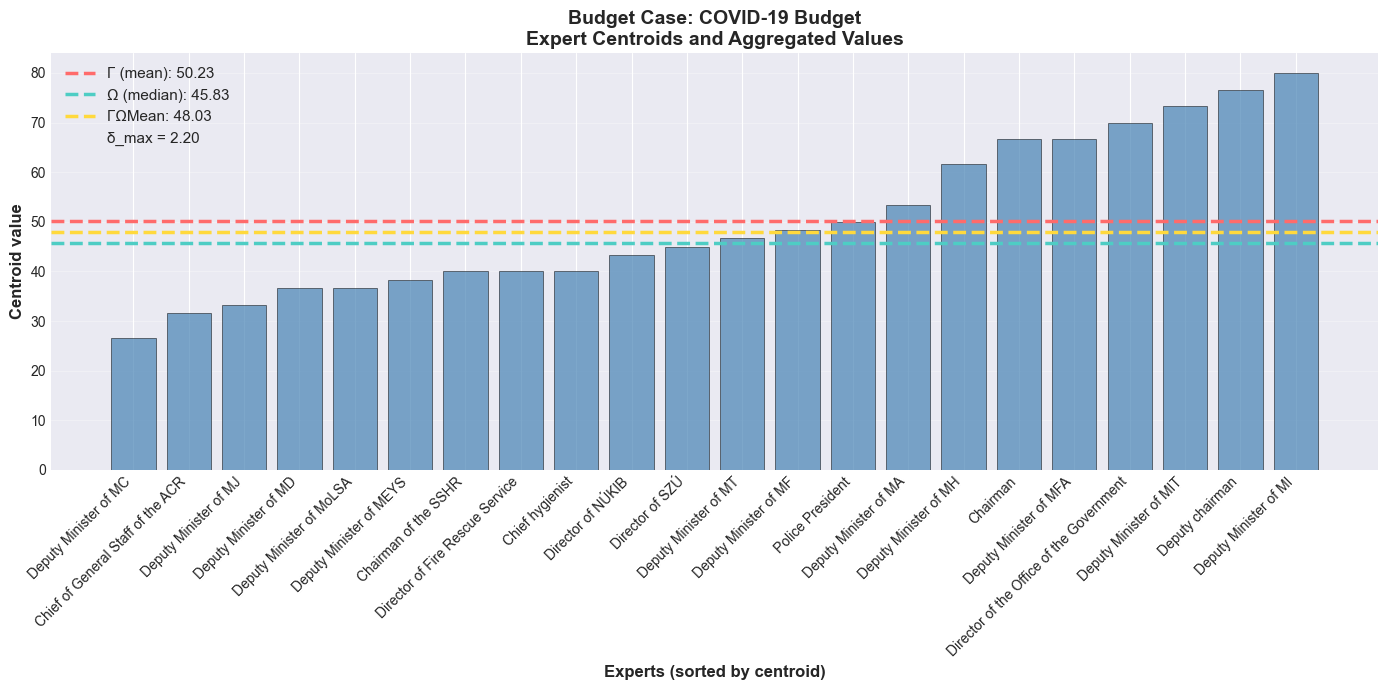

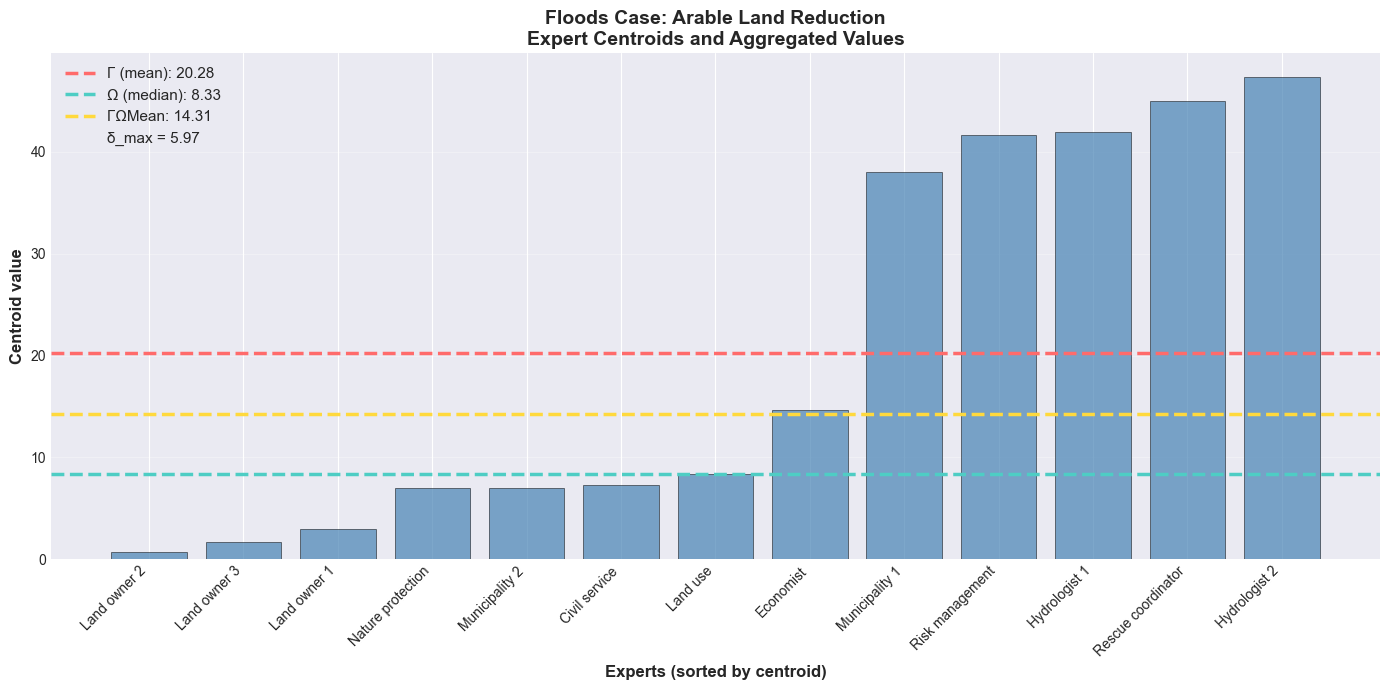

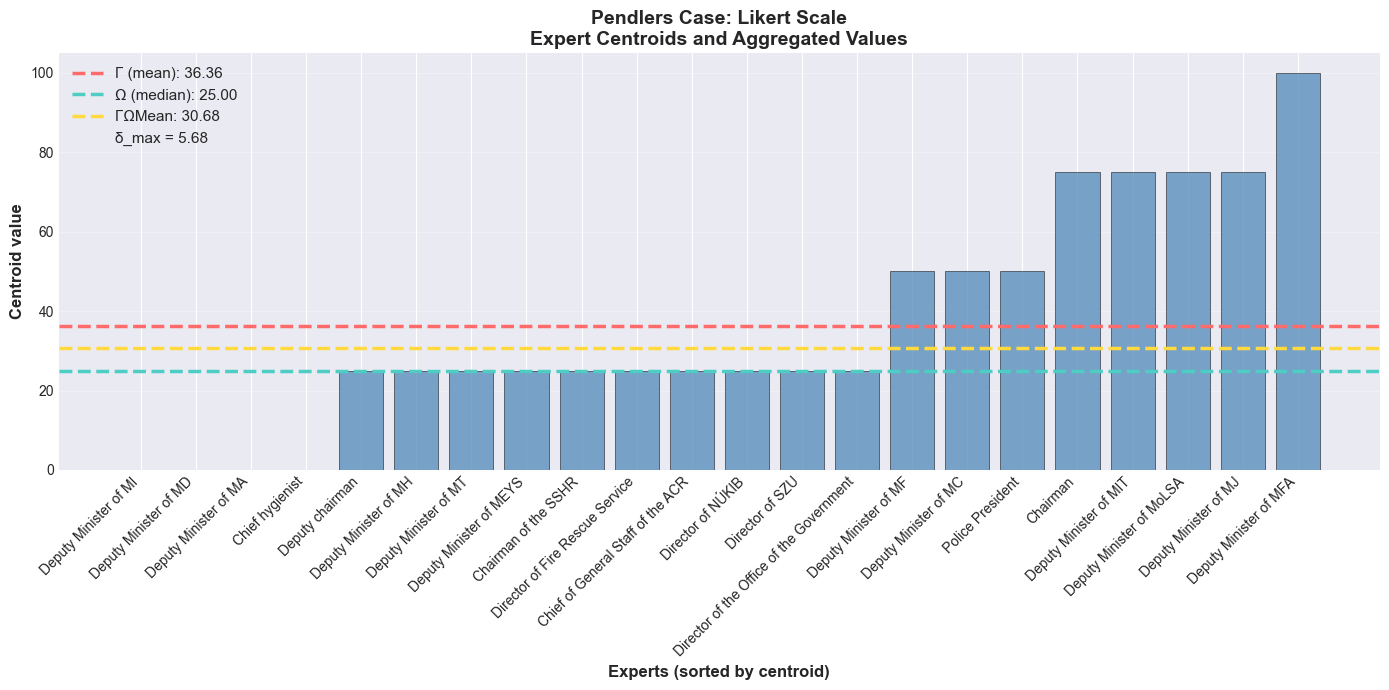

In [6]:
plot_centroid_chart(budget_opinions, budget_result, "Budget Case: COVID-19 Budget", "budget")
plot_centroid_chart(floods_opinions, floods_result, "Floods Case: Arable Land Reduction", "floods")
plot_centroid_chart(pendlers_opinions, pendlers_result, "Pendlers Case: Likert Scale", "pendlers")

### Interpretation

**Budget:** Centroids smoothly increase from 26 to 80 billion CZK. Lines Γ, Ω and ΓΩMean are very close.

**Floods:** Two clusters emerge: low values (0-15%) and high (25-45%). The distance between Γ and Ω is large.

**Pendlers:** Most centroids are in a narrow band of 24-28. Expert A22 is significantly outlying (centroid ~44).

<a id="section-sensitivity"></a>

## 4. Sensitivity Analysis

This tool is used for interactive testing of the influence of individual experts on the result.
By excluding an expert, you can observe changes in the δ_max value.

In [7]:
def create_sensitivity_analysis_widget(opinions, title, case_name):
    """Interactive widget for sensitivity analysis."""
    checkboxes = {}
    for op in opinions:
        checkboxes[op.expert_id] = widgets.Checkbox(
            value=True,
            description=f"{op.expert_id} (c={op.centroid:.1f})",
            style={"description_width": "initial"},
            layout=widgets.Layout(width="350px"),
        )

    output = widgets.Output()

    def update_plot(change=None):
        selected_opinions = [op for op in opinions if checkboxes[op.expert_id].value]

        if len(selected_opinions) < 2:
            with output:
                output.clear_output(wait=True)
                print("WARNING: Select at least 2 experts for calculation")
            return

        calculator = BeCoMeCalculator()
        result = calculator.calculate_compromise(selected_opinions)

        with output:
            output.clear_output(wait=True)
            _fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

            expert_color = "lightblue"
            for op in selected_opinions:
                x = [
                    op.opinion.lower_bound,
                    op.opinion.peak,
                    op.opinion.upper_bound,
                    op.opinion.lower_bound,
                ]
                y = [0, 1, 0, 0]
                ax1.fill(x, y, color=expert_color, alpha=0.3, edgecolor="gray", linewidth=0.5)

            for fuzzy_num, color, base_label in [
                (result.arithmetic_mean, "#FF6B6B", "Mean"),
                (result.median, "#4ECDC4", "Median"),
                (result.best_compromise, "#FFD93D", "Compromise"),
            ]:
                x = [
                    fuzzy_num.lower_bound,
                    fuzzy_num.peak,
                    fuzzy_num.upper_bound,
                    fuzzy_num.lower_bound,
                ]
                y = [0, 1, 0, 0]
                label_with_value = f"{base_label}: [{fuzzy_num.lower_bound:.2f}, {fuzzy_num.peak:.2f}, {fuzzy_num.upper_bound:.2f}]"
                ax1.plot(x, y, color=color, linewidth=2.5, label=label_with_value)

            ax1.set_xlabel("Value", fontweight="bold")
            ax1.set_ylabel("μ(x)", fontweight="bold")
            ax1.set_title(
                f"Membership Functions ({len(selected_opinions)} experts)", fontweight="bold"
            )
            ax1.legend(loc="upper left")
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(-0.05, 1.1)

            sorted_ops = sorted(selected_opinions, key=lambda x: x.centroid)
            centroids = [op.centroid for op in sorted_ops]
            expert_ids = [op.expert_id for op in sorted_ops]

            ax2.bar(range(len(centroids)), centroids, color="steelblue", alpha=0.7)
            ax2.axhline(
                y=result.arithmetic_mean.centroid,
                color="#FF6B6B",
                linestyle="--",
                linewidth=2,
                label=f"Mean: {result.arithmetic_mean.centroid:.2f}",
            )
            ax2.axhline(
                y=result.median.centroid,
                color="#4ECDC4",
                linestyle="--",
                linewidth=2,
                label=f"Median: {result.median.centroid:.2f}",
            )
            ax2.axhline(
                y=result.best_compromise.centroid,
                color="#FFD93D",
                linestyle="--",
                linewidth=2,
                label=f"Compromise: {result.best_compromise.centroid:.2f}",
            )

            ax2.set_xlabel("Experts", fontweight="bold")
            ax2.set_ylabel("Centroid", fontweight="bold")
            ax2.set_title(f"Centroids (δ_max = {result.max_error:.2f})", fontweight="bold")
            ax2.set_xticks(range(len(expert_ids)))
            ax2.set_xticklabels(expert_ids, rotation=45, ha="right")
            ax2.legend()
            ax2.grid(True, alpha=0.3, axis="y")

            plt.tight_layout()
            plt.show()

    for checkbox in checkboxes.values():
        checkbox.observe(update_plot, names="value")

    update_plot()

    checkbox_cols = []
    items_per_col = 8
    checkbox_list = list(checkboxes.values())
    for i in range(0, len(checkbox_list), items_per_col):
        checkbox_cols.append(widgets.VBox(checkbox_list[i : i + items_per_col]))

    controls = widgets.HBox(checkbox_cols)
    title_widget = widgets.HTML(f"<h3>{title} - Sensitivity Analysis</h3>")
    info_widget = widgets.HTML(
        "<p><i>Select/deselect experts to see the impact on BeCoMe result</i></p>"
    )
    display(widgets.VBox([title_widget, info_widget, controls, output]))

In [8]:
create_sensitivity_analysis_widget(budget_opinions, "Budget Case: COVID-19 Budget", "budget")
create_sensitivity_analysis_widget(floods_opinions, "Floods Case: Arable Land Reduction", "floods")
create_sensitivity_analysis_widget(pendlers_opinions, "Pendlers Case: Likert Scale", "pendlers")

### Interpretation

**Budget:** Result is robust. Excluding one expert changes δ_max minimally (±0.5).

**Floods:** Result is sensitive to extreme experts. Excluding experts from the 25-40% group significantly reduces δ_max.

**Pendlers:** Excluding A22 (outlier) reduces δ_max from 5.68 to ~2.0.

<a id="section-dashboard"></a>

## 5. Comparison Dashboard

The dashboard provides a summary comparison of all three cases in one view.

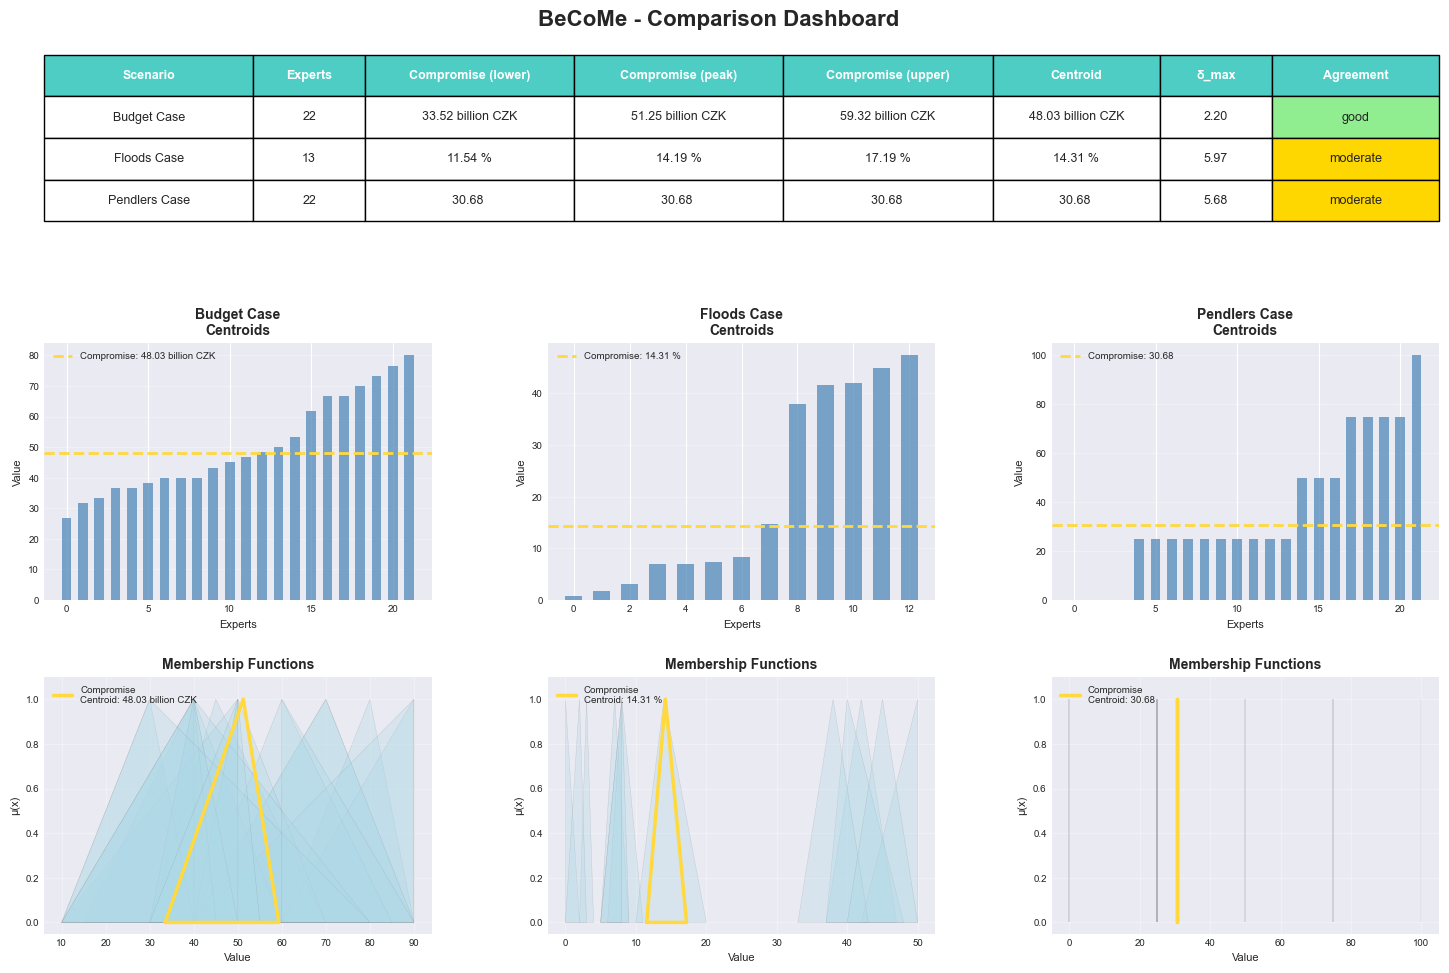

In [9]:
def create_scenario_dashboard():
    """Dashboard for comparing all three scenarios."""
    scenarios = [
        ("Budget Case", budget_result, len(budget_opinions), "billion CZK"),
        ("Floods Case", floods_result, len(floods_opinions), "%"),
        ("Pendlers Case", pendlers_result, len(pendlers_opinions), ""),
    ]

    metrics_data = []
    for name, result, num_experts, unit in scenarios:
        agreement = calculate_agreement_level(result.max_error, (5.0, 15.0))
        metrics_data.append(
            {
                "Scenario": name,
                "Experts": num_experts,
                "Compromise (lower)": f"{result.best_compromise.lower_bound:.2f} {unit}",
                "Compromise (peak)": f"{result.best_compromise.peak:.2f} {unit}",
                "Compromise (upper)": f"{result.best_compromise.upper_bound:.2f} {unit}",
                "Centroid": f"{result.best_compromise.centroid:.2f} {unit}",
                "δ_max": f"{result.max_error:.2f}",
                "Agreement": agreement,
            }
        )

    df_metrics = pd.DataFrame(metrics_data)

    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

    fig.suptitle("BeCoMe - Comparison Dashboard", fontsize=16, fontweight="bold", y=0.88)

    ax_table = fig.add_subplot(gs[0, :])
    ax_table.axis("tight")
    ax_table.axis("off")

    table = ax_table.table(
        cellText=df_metrics.values,
        colLabels=df_metrics.columns,
        cellLoc="center",
        loc="center",
        colWidths=[0.15, 0.08, 0.15, 0.15, 0.15, 0.12, 0.08, 0.12],
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.5)

    for i in range(len(df_metrics.columns)):
        table[(0, i)].set_facecolor("#4ECDC4")
        table[(0, i)].set_text_props(weight="bold", color="white")

    for i in range(1, len(df_metrics) + 1):
        for j in range(len(df_metrics.columns)):
            if j == len(df_metrics.columns) - 1:
                agreement_level = df_metrics.iloc[i - 1, j]
                if agreement_level == "good":
                    table[(i, j)].set_facecolor("#90EE90")
                elif agreement_level == "moderate":
                    table[(i, j)].set_facecolor("#FFD700")
                else:
                    table[(i, j)].set_facecolor("#FFB6C1")

    scenarios_data = [
        (budget_opinions, budget_result, "Budget Case", 0, "billion CZK"),
        (floods_opinions, floods_result, "Floods Case", 1, "%"),
        (pendlers_opinions, pendlers_result, "Pendlers Case", 2, ""),
    ]

    for opinions, result, name, col_idx, unit in scenarios_data:
        ax1 = fig.add_subplot(gs[1, col_idx])
        sorted_ops = sorted(opinions, key=lambda x: x.centroid)
        centroids = [op.centroid for op in sorted_ops]

        centroid_value = result.best_compromise.centroid
        label_text = f"Compromise: {centroid_value:.2f} {unit}".strip()

        ax1.bar(range(len(centroids)), centroids, color="steelblue", alpha=0.7, width=0.6)
        ax1.axhline(
            y=centroid_value, color="#FFD93D", linestyle="--", linewidth=2, label=label_text
        )
        ax1.set_title(f"{name}\nCentroids", fontsize=10, fontweight="bold")
        ax1.set_xlabel("Experts", fontsize=8)
        ax1.set_ylabel("Value", fontsize=8)
        ax1.tick_params(labelsize=7)
        ax1.grid(True, alpha=0.3, axis="y")
        ax1.legend(fontsize=7, loc="upper left")

        ax2 = fig.add_subplot(gs[2, col_idx])
        for op in opinions:
            x = [
                op.opinion.lower_bound,
                op.opinion.peak,
                op.opinion.upper_bound,
                op.opinion.lower_bound,
            ]
            y = [0, 1, 0, 0]
            ax2.fill(x, y, color="lightblue", alpha=0.3, edgecolor="gray", linewidth=0.3)

        x = [
            result.best_compromise.lower_bound,
            result.best_compromise.peak,
            result.best_compromise.upper_bound,
            result.best_compromise.lower_bound,
        ]
        y = [0, 1, 0, 0]
        compromise_label = (
            f"Compromise\nCentroid: {result.best_compromise.centroid:.2f} {unit}".strip()
        )
        ax2.plot(x, y, color="#FFD93D", linewidth=2.5, label=compromise_label)

        ax2.set_title("Membership Functions", fontsize=10, fontweight="bold")
        ax2.set_xlabel("Value", fontsize=8)
        ax2.set_ylabel("μ(x)", fontsize=8)
        ax2.tick_params(labelsize=7)
        ax2.legend(fontsize=7, loc="upper left")
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(-0.05, 1.1)

    plt.savefig(output_dir / "scenario_dashboard.png", dpi=300, bbox_inches="tight")
    plt.show()


create_scenario_dashboard()

### Interpretation

The visualization enables quick comparison of all three cases.
Budget shows the best agreement (green), Floods and Pendlers show moderate agreement (yellow).

<a id="section-gauge"></a>

## 6. Accuracy Indicator

The chart shows a visual indicator of expert agreement quality.
Green zone indicates good agreement (δ < 5), yellow moderate (5-15), red low (> 15).

In [10]:
def plot_accuracy_gauge(result, title, case_name, thresholds=(5.0, 15.0)):
    """Accuracy indicator as a gauge for δ_max."""
    delta_max = result.max_error
    agreement = calculate_agreement_level(delta_max, thresholds)

    if agreement == "good":
        color = "#2ECC71"
        gauge_value = 2 / 3 + (1 / 3) * (1 - delta_max / thresholds[0])
        zone = "EXCELLENT AGREEMENT"
    elif agreement == "moderate":
        color = "#F39C12"
        normalized = (delta_max - thresholds[0]) / (thresholds[1] - thresholds[0])
        gauge_value = 2 / 3 - (1 / 3) * normalized
        zone = "MODERATE AGREEMENT"
    else:
        color = "#E74C3C"
        normalized = min((delta_max - thresholds[1]) / thresholds[1], 1.0)
        gauge_value = (1 / 3) * (1 - normalized)
        zone = "LOW AGREEMENT"

    fig = plt.figure(figsize=(14, 6))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[1.2, 1])

    ax1 = fig.add_subplot(gs[0])

    zone_ranges = [
        (0, np.pi / 3, "#E74C3C", "Low"),
        (np.pi / 3, 2 * np.pi / 3, "#F39C12", "Moderate"),
        (2 * np.pi / 3, np.pi, "#2ECC71", "Good"),
    ]

    for start, end, col, _label in zone_ranges:
        theta_zone = np.linspace(start, end, 100)
        x_outer = np.cos(theta_zone)
        y_outer = np.sin(theta_zone)
        x_inner = 0.7 * np.cos(theta_zone)
        y_inner = 0.7 * np.sin(theta_zone)

        vertices = list(zip(x_outer, y_outer, strict=False)) + list(
            zip(x_inner[::-1], y_inner[::-1], strict=False)
        )
        poly = plt.Polygon(vertices, facecolor=col, alpha=0.3, edgecolor=col, linewidth=0)
        ax1.add_patch(poly)

    theta_inner = np.linspace(0, np.pi, 200)
    x_inner_circle = 0.7 * np.cos(theta_inner)
    y_inner_circle = 0.7 * np.sin(theta_inner)
    ax1.fill(
        [*x_inner_circle, x_inner_circle[-1], x_inner_circle[0]],
        [*y_inner_circle, 0, 0],
        color="white",
        zorder=2,
    )

    angle = np.pi * gauge_value
    arrow_length = 0.85
    ax1.arrow(
        0,
        0,
        arrow_length * np.cos(angle),
        arrow_length * np.sin(angle),
        head_width=0.1,
        head_length=0.1,
        fc=color,
        ec=color,
        linewidth=3,
        zorder=5,
    )

    circle = plt.Circle((0, 0), 0.15, color="black", zorder=10)
    ax1.add_patch(circle)

    ax1.text(
        0,
        -0.3,
        f"δ_max = {delta_max:.2f}",
        ha="center",
        va="top",
        fontsize=18,
        fontweight="bold",
        color="black",
    )
    ax1.text(0, -0.45, zone, ha="center", va="top", fontsize=12, fontweight="bold", color="black")

    ax1.text(-0.85, 0.5, "Good\n(< 5.0)", ha="center", fontsize=9, color="black", fontweight="bold")
    ax1.text(
        0, 1.05, "Moderate\n(5.0-15.0)", ha="center", fontsize=9, color="black", fontweight="bold"
    )
    ax1.text(0.85, 0.5, "Low\n(> 15.0)", ha="center", fontsize=9, color="black", fontweight="bold")

    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-0.6, 1.3)
    ax1.set_aspect("equal")
    ax1.axis("off")
    ax1.set_title(
        f"{title}\nExpert Agreement Quality Indicator", fontsize=12, fontweight="bold", pad=20
    )

    ax2 = fig.add_subplot(gs[1])

    ax2.barh(["δ_max"], [delta_max], color=color, height=0.5, edgecolor="black", linewidth=2)

    ax2.axvline(
        x=thresholds[0],
        color="#2ECC71",
        linestyle="--",
        linewidth=2,
        label="Good agreement (δ_max < 5.0)",
    )
    ax2.axvline(
        x=thresholds[1],
        color="#E74C3C",
        linestyle="--",
        linewidth=2,
        label="Low agreement (δ_max > 15.0)",
    )

    ax2.axvspan(0, thresholds[0], alpha=0.2, color="#2ECC71")
    ax2.axvspan(thresholds[0], thresholds[1], alpha=0.2, color="#F39C12")
    ax2.axvspan(
        thresholds[1], max(delta_max * 1.2, thresholds[1] * 1.2), alpha=0.2, color="#E74C3C"
    )

    ax2.set_xlabel("δ_max Value", fontsize=11, fontweight="bold")
    ax2.set_title("δ_max Relative to Thresholds", fontsize=12, fontweight="bold")
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis="x")
    ax2.set_xlim(0, max(delta_max * 1.2, thresholds[1] * 1.2))

    ax2.text(
        delta_max + 0.5,
        0,
        f"{delta_max:.2f}",
        va="center",
        fontsize=12,
        fontweight="bold",
        color="black",
    )

    plt.tight_layout()
    plt.savefig(output_dir / f"{case_name}_accuracy_gauge.png", dpi=300, bbox_inches="tight")
    plt.show()

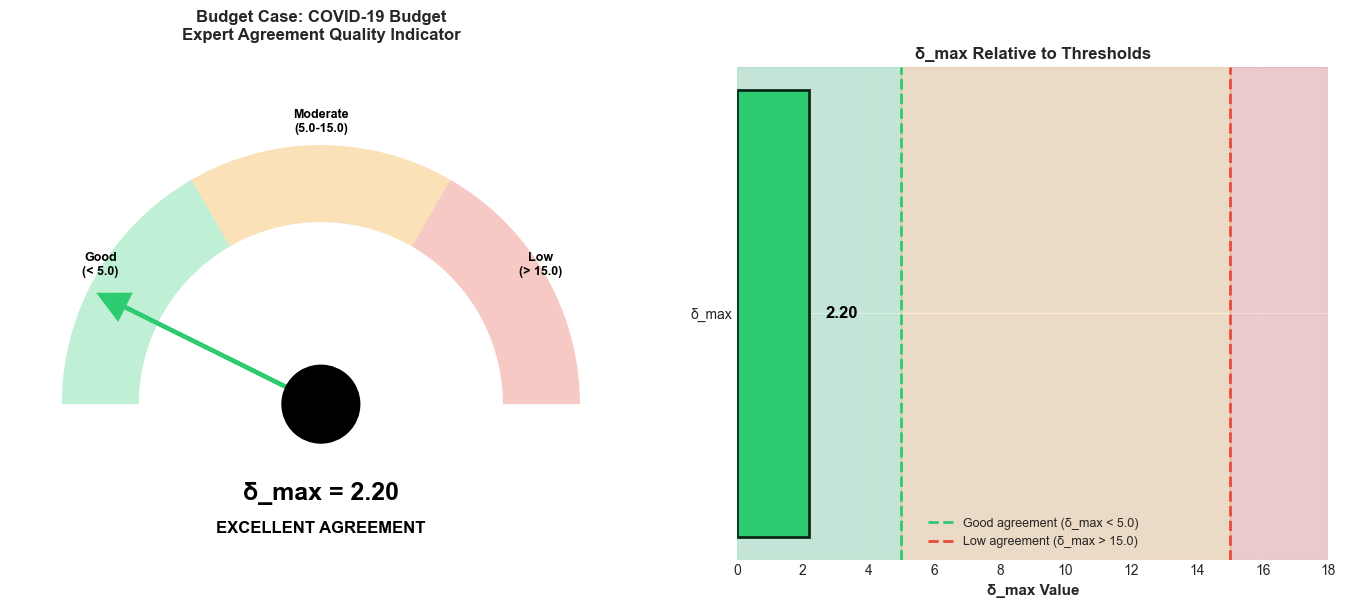

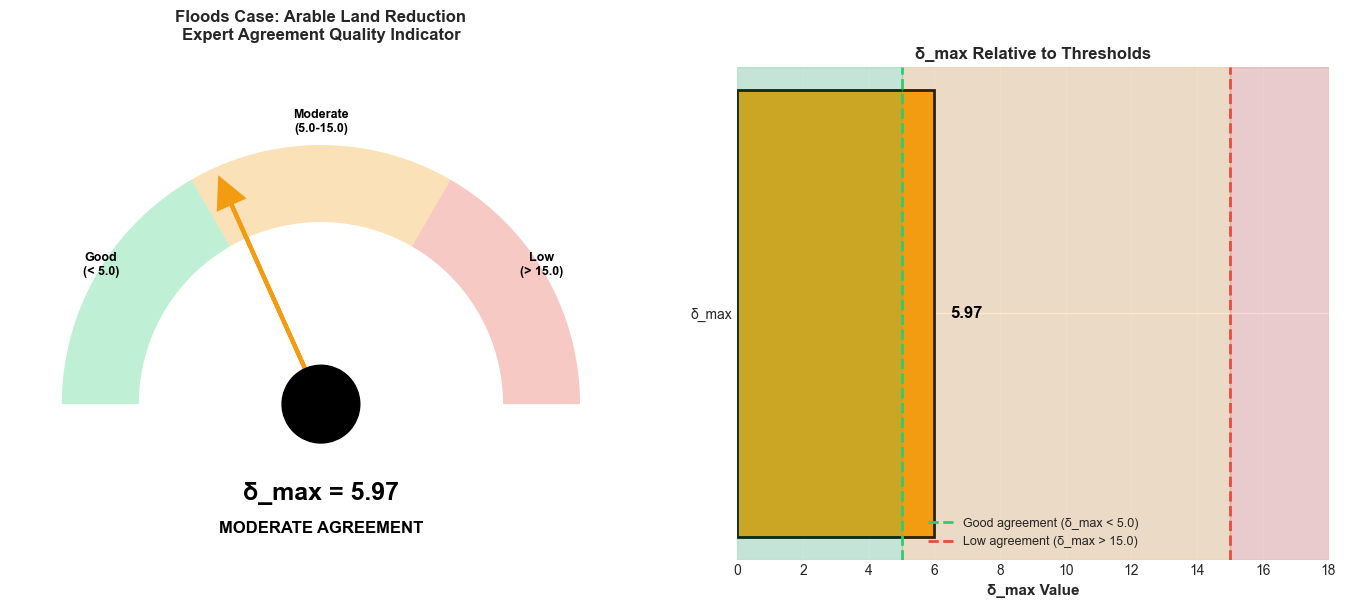

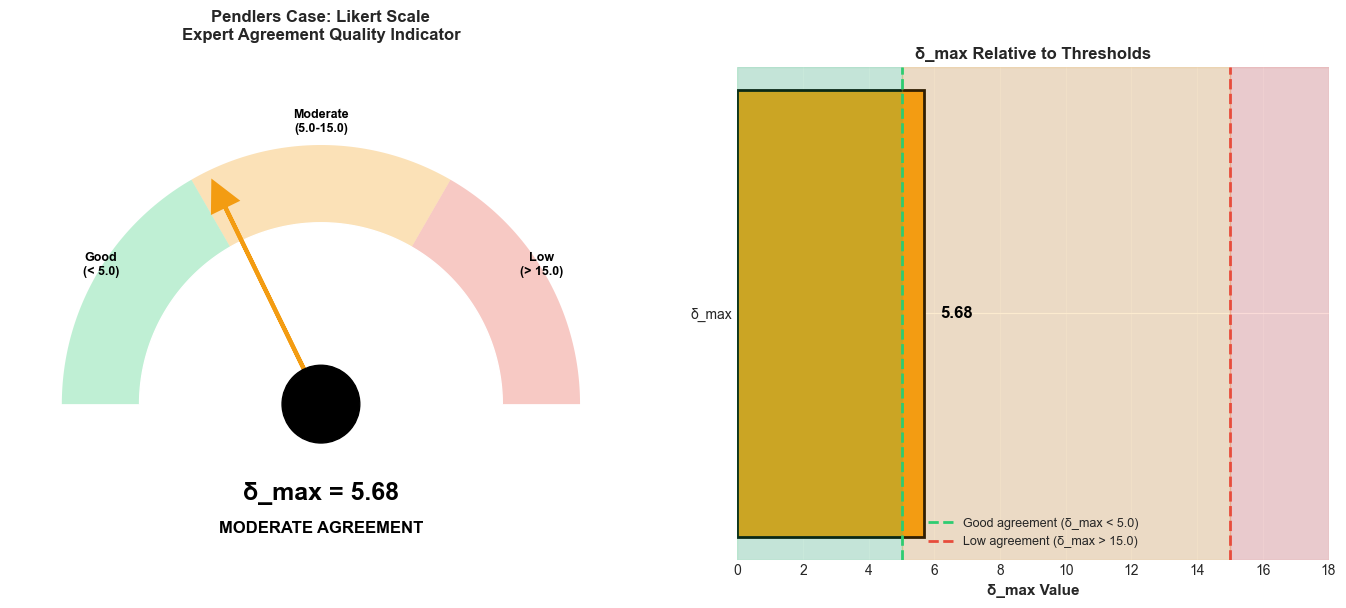

In [11]:
plot_accuracy_gauge(budget_result, "Budget Case: COVID-19 Budget", "budget")
plot_accuracy_gauge(floods_result, "Floods Case: Arable Land Reduction", "floods")
plot_accuracy_gauge(pendlers_result, "Pendlers Case: Likert Scale", "pendlers")

### Interpretation

**Budget:** Arrow points to the green zone (δ_max = 2.20). Agreement is excellent.

**Floods:** Arrow is at the border of the yellow zone (δ_max = 5.97). Agreement is moderate due to polarization.

**Pendlers:** Arrow points to the yellow zone (δ_max = 5.68). Agreement is moderate due to the outlier.

<a id="section-conclusion"></a>

## 7. Conclusion

### Results Summary

| Case | Experts | δ_max | Assessment |
|------|---------|-------|------------|
| Budget | 22 | 2.20 | Good agreement |
| Floods | 13 | 5.97 | Bimodal distribution |
| Pendlers | 22 | 5.68 | Strong outlier |

The BeCoMe method successfully aggregated expert estimates in all cases.
The highest quality is shown by Budget (low δ_max), the most complex situation occurred with Floods (polarization of opinions).